# Class that includes all the Bot Agents created to experiment with

In [17]:
import numpy as np

class BotAgent:
    def __init__(self, name):
        """Conctructor of BotAgent"""
        self.name = name


    def random_action(self, legal_actions):
        """Function that returns a random action from the legal actions"""
        return np.random.choice(legal_actions)

    def threshold_loose_action(self,round, strength, legal_actions):
        """Function for threshold loose agent"""
        if (round == 1):
            if(strength > 2):
                if('raise' in legal_actions):
                    return 'raise'
                elif('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            else:
                if('check' in legal_actions):
                    return 'check'
                else:
                    return 'call'
        elif (round == 2):
            if(strength >= 4):
                if('raise' in legal_actions):
                    return 'raise'
                elif('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            elif(strength < 4):
                if (np.random.random()<0.6):
                    if('raise' in legal_actions):
                        return 'raise'
                    elif('bet' in legal_actions):
                        return 'bet'
                    else:
                        return 'call'
                else:
                    if('check' in legal_actions):
                        return 'check'
                    else:
                        return 'fold'

    def threshold_tight_action(self,round, strength, legal_actions):
        """Function for tight threshold tight agent"""
        if (round == 1):
            if(strength > 3):
                if('raise' in legal_actions):
                    return 'raise'
                elif('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            elif(strength == 3):
                if('check' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            else:
                if('check' in legal_actions):
                    return 'check'
                else:
                    return 'fold'
        elif (round == 2):
            if(strength > 5):
                if('raise' in legal_actions):
                    return 'raise'
                elif('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            else:
                if('check' in legal_actions):
                    return 'check'
                else:
                    return 'fold'

    def super_human_action(self, round, strength, legal_actions):
        if (round == 1):
            if(strength >= 4):
                if('raise' in legal_actions):
                    return 'raise'
                elif('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            elif(strength == 3):
                if (np.random.random()<0.5):
                    if('raise' in legal_actions):
                        return 'raise'
                    elif('bet' in legal_actions):
                        return 'bet'
                    else:
                        return 'call'
                else:
                    if('check' in legal_actions):
                        return 'check'
                    else:
                        return 'call'
            elif(strength == (1 or 2)):
                    if('check' in legal_actions):
                        return 'check'
                    else:
                        return 'fold'
        elif (round == 2):
            if(strength > 5):
                if('raise' in legal_actions):
                    return 'raise'
                elif('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            elif( strength == ( 4 or 5)):
                if('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            elif( strength < 4):
                if('check' in legal_actions):
                        return 'check'
                else:
                        return 'fold'
            else:
                return np.random.choice(legal_actions)

# Player Class

In [18]:
class Player:
    def __init__(self, name, stack):
        self.name = name
        self.stack = stack
        self.opponent = False
        self.hand = []
        self.action = []

# Policy Iteration Agent

In [19]:
import numpy as np
#tranistions matrix
#0 fold, 1 check, 2 call, 3 bet , 4 raise
#prob to not hit anything=0,668, prob to hit pair=0,315, prob to hit set=0,017
#terminal states= shodown or fold
#q0-q4 = preflop states, q5-q19 = after flop state
#q0-q4= 5 different cards,q5-q9=high card, q10-q14=pair, q15-q19=set
#q20 = terminal state
#(transition probability, next state, reawrd, is terminal)

class PolicyIterationAgent:
    def __init__(self, ptype):
        self.name = 'Policy Iteration Agent'
        self.pi = None
        if((ptype == 'threshold_tight') or (ptype == 'random')):
            self.P = P_vs_tight
        else:
            self.P = P_vs_loose


    def policy_evaluation(self, pi, P, gamma = 0.95, epsilon = 1e-10):  #inputs: (1) policy to be evaluated, (2) model of the environment (transition probabilities, etc., see previous cell), (3) discount factor (with default = 1), (4) convergence error (default = 10^{-10})
        prev_V = np.zeros(len(P)) # use as "cost-to-go", i.e. for V(s')
        while True:
            V = np.zeros(len(P)) # current value function to be learnerd
            for s in range(len(P)):  # do for every state
                for prob, next_state, reward, done in P[s][pi(s)]:  # calculate one Bellman step --> i.e., sum over all probabilities of transitions and reward for that state, the action suggested by the (fixed) policy, the reward earned (dictated by the model), and the cost-to-go from the next state (which is also decided by the model)
                    V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
            if np.max(np.abs(prev_V - V)) < epsilon: #check if the new V estimate is close enough to the previous one;
                break # if yes, finish loop
            prev_V = V.copy() #freeze the new values (to be used as the next V(s'))
        return V

    def policy_improvement(self, V, P, gamma=0.95):  # takes a value function (as the cost to go V(s')), a model, and a discount parameter
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64) #create a Q value array
        for s in range(len(P)):        # for every state in the environment/model
            for a in range(len(P[s])):  # and for every action in that state
                for prob, next_state, reward, done in P[s][a]:  #evaluate the action value based on the model and Value function given (which corresponds to the previous policy that we are trying to improve)
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        new_pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]  # this basically creates the new (improved) policy by choosing at each state s the action a that has the highest Q value (based on the Q array we just calculated)
        # lambda is a "fancy" way of creating a function without formally defining it (e.g. simply to return, as here...or to use internally in another function)
        # you can implement this in a much simpler way, by using just a few more lines of code -- if this command is not clear, I suggest to try coding this yourself

        return new_pi

    # policy iteration is simple, it will call alternatively policy evaluation then policy improvement, till the policy converges.

    def policy_iteration(self, P,gamma = 0.95, epsilon = 1e-10):

        action = []
        random_actions = np.random.choice(tuple(P[0].keys()), len(P))     # start with random actions for each state
        pi = lambda s: {s:a for s, a in enumerate(random_actions)}[s]
        t = 0
        while True:
            old_pi = {s: pi(s) for s in range(len(P))}  #keep the old policy to compare with new
            V = self.policy_evaluation(pi,P,gamma,epsilon)   #evaluate latest policy --> you receive its converged value function
            pi = self.policy_improvement(V,P,gamma)          #get a better policy using the value function of the previous one just calculated
            t += 1
            if old_pi == {s:pi(s) for s in range(len(P))}: # you have converged to the optimal policy if the "improved" policy is exactly the same as in the previous step
                break
        #print('converged after %d iterations' %t) #keep track of the number of (outer) iterations to converge
        return V,pi


#tranistions matrix
#0 fold, 1 check, 2 call, 3 bet , 4 raise
#prob to not hit anything=0,668, prob to hit pair=0,315, prob to hit set=0,017
#terminal states= shodown or fold
#q0-q4 = preflop states, q5-q19 = after flop state
#q0-q4= 5 different cards,q5-q9=high card, q10-q14=pair, q15-q19=set
#q20 = terminal state
#(transition probability, next state, reawrd, is terminal)
P_vs_loose = {
    0: {
        0: [(1, 20,20, True)
        ],
        1: [(0.7, 5, 20, False),
            (0.283, 10, 20, False),
            (0.017, 15, 20, False)
        ],
        2: [(0.7, 5, -10, False),
            (0.283, 10, -10, False),
            (0.017, 15, -10, False)
        ],
        3: [(0.7, 5, -200, False),
            (0.283, 10, -200, False),
            (0.017, 15, -200, False)
        ],
        4: [(0.7, 5, -200, False),
            (0.283, 10, -200, False),
            (0.017, 15, -200, False)
        ]
    },
    1: {
        0: [(1, 20, 20, True)
        ],
        1: [(0.7, 6, 20, False),
            (0.283, 11, 20, False),
            (0.017, 16, 20, False)
        ],
        2: [(0.7, 6, -20, False),
            (0.283, 11, -20, False),
            (0.017, 16, -20, False)
        ],
        3: [(0.7, 6, -200, False),
            (0.283, 11, -200, False),
            (0.017, 16, -200, False)
        ],
        4: [(0.7, 6, -200, False),
            (0.283, 11, -200, False),
            (0.017, 16, -200, False)
        ]
    },
    2: {
        0: [(1, 20, -20, True)
        ],
        1: [(0.7, 7, 20, False),
            (0.283, 12, 20, False),
            (0.017, 17, 20, False)
        ],
        2: [(0.7, 7, -20, False),
            (0.283, 12, -20, False),
            (0.017, 17, -20, False)
        ],
        3: [(0.7, 7, -200, False),
            (0.283, 12, -200, False),
            (0.017, 17, -200, False)
        ],
        4: [(0.7, 7, -200, False),
            (0.283, 12, -200, False),
            (0.017, 17, -200, False)
        ]
    },
    3: {
        0: [(1, 20, -200, True)
        ],
        1: [(0.7, 8, -200, False),
            (0.283, 13, -200, False),
            (0.017, 18, -200, False)
        ],
        2: [(0.7, 8, -200, False),
            (0.283, 13, -200, False),
            (0.017, 18, -200, False)
        ],
        3: [(0.7, 8, 200, False),
            (0.283, 13, 200, False),
            (0.017, 18, 200, False)
        ],
        4: [(0.7, 8, 200, False),
            (0.283, 13, 200, False),
            (0.017, 18, 200, False)
        ]
    },
    4: {
        0: [(1, 20, -200, True)
        ],
        1: [(0.7, 9, -200, False),
            (0.283, 14, -200, False),
            (0.017, 19, -200, False)
        ],
        2: [(0.7, 9, -200, False),
            (0.283, 14, -200, False),
            (0.017, 19, -200, False)
        ],
        3: [(0.7, 9, 200, False),
            (0.283, 14, 200, False),
            (0.017, 19, 200, False)
        ],
        4: [(0.7, 9, 200, False),
            (0.283, 14, 200, False),
            (0.017, 19, 200, False)
        ]
    },
    5: {
        0: [(1, 20, 20, True)],
        1: [(1, 20, 20, True)],
        2: [(1, 20, -20, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    6: {
        0: [(1, 20, 20, True)],
        1: [(1, 20, 20, True)],
        2: [(1, 20, -20, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    7: {
        0: [(1, 20, 0, True)],
        1: [(1, 20, 20, True)],
        2: [(1, 20, -20, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    8: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, 10, True)],
        2: [(1, 20, 20, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    9: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, 10, True)],
        2: [(1, 20, 20, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    10: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    11: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    12: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    13: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    14: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    15: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    16: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    17: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    18: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    19: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    20: {
        0: [(1, 20, 0, True)],
        1: [(1, 20, 0, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 0, True)],
        4: [(1, 20, 0, True)]
    }
}

P_vs_tight = {
    0: {
        0: [(1, 20,-200, True)
        ],
        1: [(0.7, 5, -200, False),
            (0.283, 10, -200, False),
            (0.017, 15, -200, False)
        ],
        2: [(0.7, 5, 200, False),
            (0.283, 10, 200, False),
            (0.017, 15, 200, False)
        ],
        3: [(0.7, 5, -200, False),
            (0.283, 10, -200, False),
            (0.017, 15, -200, False)
        ],
        4: [(0.7, 5, -200, False),
            (0.283, 10, -200, False),
            (0.017, 15, -200, False)
        ]
    },
    1: {
        0: [(1, 20, -200, True)
        ],
        1: [(0.7, 6, -200, False),
            (0.283, 11, -200, False),
            (0.017, 16, -200, False)
        ],
        2: [(0.7, 6, 200, False),
            (0.283, 11, 200, False),
            (0.017, 16, 200, False)
        ],
        3: [(0.7, 6, -200, False),
            (0.283, 11, -200, False),
            (0.017, 16, -200, False)
        ],
        4: [(0.7, 6, -200, False),
            (0.283, 11, -200, False),
            (0.017, 16, -200, False)
        ]
    },
    2: {
        0: [(1, 20, -200, True)
        ],
        1: [(0.7, 7, -200, False),
            (0.283, 12, -200, False),
            (0.017, 17, -200, False)
        ],
        2: [(0.7, 7, 200, False),
            (0.283, 12, 200, False),
            (0.017, 17, 200, False)
        ],
        3: [(0.7, 7, -200, False),
            (0.283, 12, -200, False),
            (0.017, 17, -200, False)
        ],
        4: [(0.7, 7, -200, False),
            (0.283, 12, -200, False),
            (0.017, 17, -200, False)
        ]
    },
    3: {
        0: [(1, 20, -200, True)
        ],
        1: [(0.7, 8, -200, False),
            (0.283, 13, -200, False),
            (0.017, 18, -200, False)
        ],
        2: [(0.7, 8, 200, False),
            (0.283, 13, 200, False),
            (0.017, 18, 200, False)
        ],
        3: [(0.7, 8, -200, False),
            (0.283, 13, -200, False),
            (0.017, 18, -200, False)
        ],
        4: [(0.7, 8, -200, False),
            (0.283, 13, -200, False),
            (0.017, 18, -200, False)
        ]
    },
    4: {
        0: [(1, 20, -200, True)
        ],
        1: [(0.7, 9, -200, False),
            (0.283, 14, -200, False),
            (0.017, 19, -200, False)
        ],
        2: [(0.7, 9, -200, False),
            (0.283, 14, -200, False),
            (0.017, 19, -200, False)
        ],
        3: [(0.7, 9, 200, False),
            (0.283, 14, 200, False),
            (0.017, 19, 200, False)
        ],
        4: [(0.7, 9, 200, False),
            (0.283, 14, 200, False),
            (0.017, 19, 200, False)
        ]
    },
    5: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    6: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    7: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    8: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    9: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    10: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    11: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    12: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 200, True)],
        3: [(1, 20, -200, True)],
        4: [(1, 20, -200, True)]
    },
    13: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    14: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    15: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    16: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    17: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    18: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    19: {
        0: [(1, 20, -200, True)],
        1: [(1, 20, -200, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 200, True)],
        4: [(1, 20, 200, True)]
    },
    20: {
        0: [(1, 20, 0, True)],
        1: [(1, 20, 0, True)],
        2: [(1, 20, 0, True)],
        3: [(1, 20, 0, True)],
        4: [(1, 20, 0, True)]
    }
}

# QLearning Agent

In [20]:
import numpy as np
# from bot_agents import BotAgent

class QLearningAgent:

    def __init__(self,learning_rate=0.3, discount=0.9, epsilon=0.1):
        """Initialize the QLearning Agent"""

        # Initialize all the values for learning rate, gamma, epsilon
        self.name = "QLearning Agent"
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon

        # Generate the state space
        self.state_space = self.generate_state_space()

        # available actions
        self.actions = ['fold', 'check', 'bet', 'call', 'raise']

        # initialize q table as zeros
        self.q_table = np.zeros((len(self.state_space), len(self.actions)))
        # boolean value to see if the agent is in training or not is needed for some prints
        self.in_training = True



    def generate_state_space(self):
        """Function that initializes the state space."""
        # Preflop 0-4 states
        # Flop  5-9 with High card
        #       10-14 with pair
        #       15-19 with set
        state_space = {}
        for i in range(20):
            state_space[i] = i
        return state_space

    def pick_action(self, state, legal_actions, epsilon):
        """Function to pick action It uses ε-greedy algorithm."""
        # get q value for current state
        action_val = self.q_table[self.state_space[state]]
        # get q values only for legal actions
        legal_action_val = [action_val[action] for action in range(len(legal_actions))]

        # explore using a random action
        if(np.random.uniform(0,1) < epsilon):
            action = legal_actions[np.random.choice(len(legal_action_val),1)[0]]
        else:
            action = legal_actions[np.argmax(legal_action_val)]
        return action


    def convert_action_into_number(self, action):
        """Function to convert action to number"""
        # fold = 0
        # check = 1
        # call = 2
        # bet = 3
        # raise = 4

        if(action == 'fold'):
            return 0
        elif(action == 'check'):
            return 1
        elif(action == 'call'):
            return 2
        elif(action == 'bet'):
            return 3
        elif(action == 'raise'):
            return 4
        else:
            return 0

    def update_q_table(self, state, action, reward, next_state):
        #
        action_num = self.convert_action_into_number(action)
        st = self.state_space[state]
        current_q = self.q_table[st ,action_num]
        max_q = np.max(self.q_table[self.state_space[next_state]])
        new_q = current_q + self.learning_rate * (self.discount * max_q - current_q + reward)
        self.q_table[self.state_space[state], action_num] = new_q

    def print_q_table(self):
        print("State                | Action               | Q-Value")
        print("-----------------------------------------------------")
        for state in self.state_space:
            s = self.state_space[state]
            for a, action in enumerate(self.actions):
                tmp = str(state)
                print("{:<20} | {:<20} | {:.2f}".format(tmp, action, self.q_table[s][a]), flush=True)


    def train_agent(self,game, opponent_type, num_episodes = 20000):
        """Function that trains our agent against an opponent. You will run num_episodes rounds"""

        # put starting stack very high so that there is no need for reseting every round
        starting_stack = 100000
        # the bot you're playing against
        bot_agent = BotAgent(opponent_type)
        # create 2 players
        player_one, player_two = game.create_players(starting_stack,'giannis','tzortzis')
        # pointer to see which player plays 1st in each round
        goes_first = 0
        # loop for training
        for episode in range(num_episodes):
            # play a round
            self.run_episode(game,starting_stack,player_one,player_two,bot_agent,goes_first)
            # change who is going to play first in the next round
            goes_first += 1
            # self.epsilon = (episode+1)**(-1/4)



    def state(self, strength, round):
        # Function that tells in which state we are depending in the hand and the round we are on
        if(round == 1):
            return strength - 1
        else:
            return strength + 4

    def run_episode(self,game,starting_stack,player_one,player_two, bot_agent,goes_first):
        """Function that simulates a round in a poker game"""

        # initialize some actions
        starting_actions = ['bet', 'check']
        actions_after_check = ['check', 'bet']
        actions_after_raise = ['call', 'fold']
        actions_after_bet = ['call', 'fold', 'raise']
        round = 1
        # create the deck
        deck = game.create_deck()
        while(True):
            # if in round 1(pre flop then see who is playing first or second)
            if(round == 1):
                pot = 1

                if(goes_first % 2 == 0):
                    plays_first = player_one
                    plays_first.opponent = False
                    plays_second = player_two
                    plays_second.opponent = True
                else:
                    plays_first = player_two
                    plays_first.opponent = True
                    plays_second = player_one
                    plays_second.opponent = False

                # deal cards in the players and the board
                [plays_first.hand, plays_second.hand, board] = game.deal_cards(deck)
                # restore the deck for next usage
                deck = game.restore_deck([plays_first.hand, plays_second.hand, board[0], board[1]], deck)

            # ask the player who speaks 1st his action. If he is our agebt it goes to pick_action
            plays_first.action = game.ask_action_for_training(plays_first.opponent, starting_actions, bot_agent, round, game.calculate_hand_strength(plays_first.hand, board,round),self)
            # if plays_first is our player update q table otherwise do nothing
            if(plays_first.opponent == False):
                next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                self.update_q_table(next_state, plays_first.action, 0, next_state)
            if(plays_first.action == 'check'):
                plays_second.action = game.ask_action_for_training(plays_second.opponent, actions_after_check, bot_agent, round, game.calculate_hand_strength(plays_second.hand, board ,round),self)
                if(plays_second.action == 'check'):
                    # if check check sequence and in round 1 then
                    if (round == 1):
                        # get current state
                        current_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                        # change round
                        round = 2
                        # if plays_second is our player get the next state and update the q table
                        if(plays_second.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                            self.update_q_table(current_state, plays_second.action, 0, next_state)
                    # if check check sequence and in round 2 then we are at showdown
                    elif(round == 2):
                        # calcualte winner
                        winner = game.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                        plays_first.stack, plays_second.stack , reward = game.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)
                        # if plays_second is our player get the next state and update the q table
                        if(plays_second.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                            # if split then reward = 0
                            if(winner == 'split'):
                                self.update_q_table(next_state,plays_second.action,0,next_state)
                            # if winner = plays_first then -reward
                            elif(winner == 'player_one'):
                                self.update_q_table(next_state,plays_second.action,-reward,next_state)
                            # else winner = p2 then +reward
                            else:
                                self.update_q_table(next_state, plays_second.action, reward, next_state)

                        # if you are p1 then get the rewards depending if you won or not
                        elif(plays_first.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                            if( winner == 'split'):
                                self.update_q_table(next_state,plays_first.action,0,next_state)
                            elif(winner == 'player_one'):
                                self.update_q_table(next_state,plays_first.action,reward,next_state)
                            else:
                                self.update_q_table(next_state, plays_first.action, -reward, next_state)
                        round = 1
                        return
                elif(plays_second.action == 'bet'):
                    # increment 1 to pot if action is bet
                    pot += 1
                    # if my agent = p2 udate q table for the action bet
                    if(plays_second.opponent == False):
                        next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                        self.update_q_table(next_state, plays_second.action, 0, next_state)
                    plays_first.action = game.ask_action_for_training(plays_first.opponent, actions_after_raise, bot_agent, round, game.calculate_hand_strength(plays_first.hand, board,round),self)
                    if(plays_first.action == 'call'):
                        # increment pot
                        pot += 1
                        # if in round 1 and sequence bet call
                        if (round == 1):
                            # get curr state
                            current_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                            round = 2
                            # if p1 = our agent then get next state and update q table
                            if(plays_first.opponent == False):
                                next_state = self.state(game.calculate_hand_strength(plays_first.hand, board, round), round)
                                self.update_q_table(current_state, plays_first.action, 0, next_state)
                        #  if in round 2 then calculate winner and update q table of your player according to the winnings
                        elif(round == 2):
                            winner = game.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                            plays_first.stack, plays_second.stack, reward = game.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)
                            if(plays_second.opponent == False):
                                next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                                if(winner == 'split'):
                                    self.update_q_table(next_state,plays_second.action,0,next_state)
                                elif(winner == 'player_one'):
                                    self.update_q_table(next_state,plays_second.action, -reward,next_state)
                                else:
                                    self.update_q_table(next_state, plays_second.action, reward, next_state)
                            if(plays_first.opponent == False):
                                next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                                if( winner == 'split'):
                                    self.update_q_table(next_state,plays_first.action,0,next_state)
                                elif(winner == 'player_one'):
                                    self.update_q_table(next_state,plays_first.action,reward,next_state)
                                else:
                                    self.update_q_table(next_state, plays_first.action, -reward, next_state)
                            round = 1
                            return
                    # if sequence bet-fold then update q table of your player. If you folded the update with -q reward else +reward
                    elif(plays_first.action == 'fold'):
                        plays_first.stack, plays_second.stack, reward = game.calculate_blinds(pot, 'player_two', True, plays_first.stack, plays_second.stack, starting_stack)
                        if(plays_first.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_first.hand, board, round), round)
                            self.update_q_table(next_state,plays_first.action, -reward, next_state)
                        elif(plays_second.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                            self.update_q_table(next_state, plays_second.action, reward, next_state)
                        round = 1
                        return

            elif(plays_first.action == 'bet'):
                # increment pot by 1
                pot += 1
                # get p2 action
                plays_second.action = game.ask_action_for_training(plays_second.opponent, actions_after_bet, bot_agent, round, game.calculate_hand_strength(plays_second.hand, board,round),self)
                # if p2 action = call
                if(plays_second.action == 'call'):
                    pot += 1
                    # if in round 1 and sequence bet call then
                    if (round == 1):
                        current_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                        # go to next round
                        round = 2
                        # if my agent is p2 then update q table for action call in round 1
                        if(plays_second.opponent == False):
                            # get next state
                            next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                            # update q table
                            self.update_q_table(current_state, plays_second.action, 0, next_state)
                    # if in round 2 and sequence bet-call
                    elif(round == 2):
                        # go to showdown
                        winner = game.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                        plays_first.stack, plays_second.stack, reward = game.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)
                        # depending on the winner and which player you are update q table with the proportional +/-reward
                        if(plays_second.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                            if(winner == 'split'):
                                self.update_q_table(next_state, plays_second.action, 0, next_state)
                            elif(winner == 'player_one'):
                                self.update_q_table(next_state, plays_second.action, -reward, next_state)
                            else:
                                self.update_q_table(next_state, plays_second.action, reward, next_state)

                        elif(plays_first.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                            if(winner == 'split'):
                                self.update_q_table(next_state, plays_first.action, 0, next_state)
                            elif(winner == 'player_one'):
                                self.update_q_table(next_state, plays_first.action, reward, next_state)
                            else:
                                self.update_q_table(next_state, plays_first.action, -reward, next_state)

                        round = 1
                        return

                # if avction bet and p2 folds then update q table accordingly
                # if you folded update q table with -reward else with +reward
                elif(plays_second.action == 'fold'):
                    plays_first.stack, plays_second.stack, reward = game.calculate_blinds(pot, 'player_one', True, plays_first.stack, plays_second.stack, starting_stack)
                    if(plays_second.opponent == False):
                        next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                        self.update_q_table(next_state, plays_second.action, -reward, next_state)
                    elif(plays_first.opponent == False):
                        next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                        self.update_q_table(next_state, plays_first.action, reward, next_state)

                    round = 1
                    return

                # if bet-raise sequence then
                elif(plays_second.action == 'raise'):
                    # increment pot by
                    pot += 2
                    # if you are the one who raised you juct took an action so update q table
                    if(plays_second.opponent == False):
                        next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                        self.update_q_table(next_state, plays_second.action, 0, next_state)

                    plays_first.action = game.ask_action_for_training(plays_first.opponent, actions_after_raise, bot_agent, round, game.calculate_hand_strength(plays_first.hand, board,round),self)
                    # if bet-raise-call
                    if(plays_first.action == 'call'):
                        pot += 1
                        # if in round 1 Change round and if you are the one who called update q table by taking the next state
                        if (round == 1):
                            current_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                            round = 2
                            if(plays_first.opponent == False):
                                next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                                self.update_q_table(current_state, plays_first.action, 0, next_state)
                        # if in round 2 then you are at showdown
                        elif(round == 2):
                            # calculate winner
                            winner = game.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                            plays_first.stack, plays_second.stack, reward = game.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)
                            # according to who you are then update q table
                            if(plays_first.opponent == False):
                                next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                                if(winner == 'split'):
                                    self.update_q_table(next_state, plays_first.action, 0, next_state)
                                elif(winner == 'player_one'):
                                    self.update_q_table(next_state, plays_first.action, reward, next_state)
                                else:
                                    self.update_q_table(next_state, plays_first.action, -reward, next_state)
                            elif(plays_second.opponent == False):
                                next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                                if(winner == 'split'):
                                    self.update_q_table(next_state, plays_second.action, 0, next_state)
                                elif(winner == 'player_one'):
                                    self.update_q_table(next_state, plays_second.action, -reward, next_state)
                                else:
                                    self.update_q_table(next_state, plays_second.action, reward, next_state)

                            round = 1
                            return
                    # if bet-raise-fold then update q table and and the episode
                    elif(plays_first.action == 'fold'):
                        plays_first.stack, plays_second.stack, reward = game.calculate_blinds(pot, 'player_two', True, plays_first.stack, plays_second.stack, starting_stack)
                        if(plays_first.opponent == False):
                            next_state = self.state(game.calculate_hand_strength(plays_first.hand, board,round), round)
                            self.update_q_table(next_state, plays_first.action, -reward, next_state)
                        else:
                            next_state = self.state(game.calculate_hand_strength(plays_second.hand, board,round), round)
                            self.update_q_table(next_state, plays_second.action, reward, next_state)

                        round = 1
                        return



# Poker Game Main Method


********** Choose your Agent **********
1) Policy Iteration
2) Q-Learning
***************************************
Choose 1 for Policy Iteration or 2 for Q-Learning:
1
******** Choose your Opponent *********
1) Random
2) Threshold Loose
3) Threshold Tight
***************************************
Choose 1 for Random, 2 for Threshold Loose or 3 for Threshold Tight:
3

******************** SIMPLE POKER GAME ********************

.........................................................
(my_player : plays first this turn)
Going to Hand 0 :

********** ROUND 1 **********
my_player's Hand:
----------------
┌─────────┐
│J♥       │
│         │
│         │
│    ♥    │
│         │
│         │
│       J♥│
└─────────┘
opponent_player's Hand:
----------------
┌─────────┐
│Q♣       │
│         │
│         │
│    ♣    │
│         │
│         │
│       Q♣│
└─────────┘
My action is : bet
Opponent's action is : call

********** ROUND 2 **********
This is the Board:
---------------------------
┌─────────┐ 

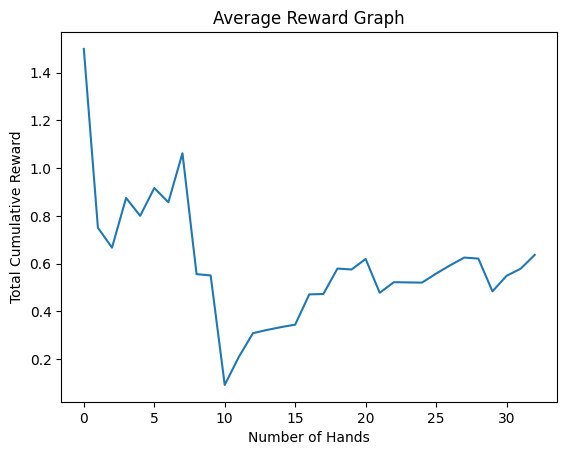

In [44]:
# from player import Player
# from bot_agents import BotAgent
# from policy_iteration import PolicyIterationAgent
# from qlearning import QLearningAgent
import numpy as np
import matplotlib.pyplot as plt

class Game:
    def __init__(self):
        """Constructor of poker game"""
        self.name = "poker"

    def create_deck(self):
        """
        Function that creates the deck for every possible card and every possible suit

        Returns:
            (list): The state of the player
        """
        deck = []
        # The suits
        suit_list = ['S', 'H', 'D', 'C']
        # The cards
        rank_list = ['T', 'J', 'Q', 'K', 'A']
        # FOr every possible scenario append to deck
        for suit in suit_list:
            for rank in rank_list:
                card = f'{rank} of {suit}'
                deck.append(card)
        return deck

    def deal_cards(self, deck):
        """
        Function that deals the cards for the round

        Args:
            deck (list): A list of the deck

        Returns:
            (handp1, handp2, board): returns the
        """

        cards = []
        # Deal 4 and remove them from the deck
        for i in range(4):
            card = np.random.choice(deck)
            cards.append(card)
            deck.remove(card)
        return cards[0], cards[1], cards[2:4]

    def print_card(self, hand, player):
        """
        Function used to print the cards beautifully

        Args:
            hand (list): The hand suit and number
            player (str): Player name

        """

        suit = self.find_suit(hand)
        print(f"{player}'s Hand:")
        print("----------------")
        print("┌─────────┐")
        print(f"│{hand[0]}{suit}       │")
        print("│         │")
        print("│         │")
        print(f"│    {suit}    │")
        print("│         │")
        print("│         │")
        print(f"│       {hand[0]}{suit}│")
        print("└─────────┘")

    def print_board(self, board):
        """
        Function that prints the board beautifully taken by rlcard

        Args:
            board (list): The board list contains 2 cards

        """

        suit_one = self.find_suit(board[0])
        suit_two = self.find_suit(board[1])
        print("This is the Board:")
        print("---------------------------")
        print("┌─────────┐", end="  ")
        print("┌─────────┐")
        print(f"│{board[0][0]}{suit_one}       │", end="  ")
        print(f"│{board[1][0]}{suit_two}       │")
        print("│         │", end="  ")
        print("│         │")
        print("│         │", end="  ")
        print("│         │")
        print(f"│    {suit_one}    │", end="  ")
        print(f"│    {suit_two}    │")
        print("│         │", end="  ")
        print("│         │")
        print("│         │", end="  ")
        print("│         │")
        print(f"│       {board[0][0]}{suit_one}│", end="  ")
        print(f"│       {board[1][0]}{suit_two}│")
        print("└─────────┘", end="  ")
        print("└─────────┘")

    def find_suit(self, hand):
        """
        Function that converts the character of the suit

        Args:
            hand (list): the hand suit and number

        Returns:
            (str): the symbol of the suit
        """

        if (hand[5] == 'C'):
            suit = '♣'
        elif(hand[5] == 'H'):
            suit = '♥'
        elif(hand[5] == 'S'):
            suit = '♠'
        elif(hand[5] == 'D'):
            suit = '♦'
        return suit

    def create_players(self, starting_stack, name_one, name_two):
        """
        Function that creates the 2 players

        Args:
            starting_stack (int): The staring stack to initialize the stack of the players
            name_one (str): Name of player 1
            name_two (str): Name of player 2

        Returns:
            (dict): The state of the player
        """
        # player1
        player_one = Player(name_one, starting_stack)
        # player2
        player_two = Player(name_two, starting_stack)

        return player_one, player_two

    def game_not_over(self, stack_one, stack_two, name_one, name_two):
        """
        Function that checks that the game is over or not

        Args:
            stack_one (int): Stack of Player 1
            stack_two (str): Stack of Player 2
            name_one (str): Name of player 1
            name_two (str): Name of player 2

        Returns:
            (boolean): true if game is over. False otherwise
        """
        if(stack_one > 0 and stack_two > 0):
            return True
        else:
            print("=================================")
            print("********** Game is over *********")
            print("=================================")
            if(stack_one <= 0):
                print(f"\n{name_one} Looses | {name_two} Wins!\n")
            elif(stack_two <= 0):
                print(f"\n{name_two} Looses | {name_one} Wins!\n")
            return False


    def restore_deck(self, cards, deck):
        """
        Function that restores the deck. Meaning that returns to the deck the hand's of the players and the board

        Args:
            cards (list): Cards to restore
            deck  (list): the list to extend

        Returns:
            (boolean): true if game is over. False otherwise
        """
        deck.extend(cards)
        return deck

    def calculate_blinds(self, total_pot, winner, not_showdown, stack_one, stack_two, start_stack):
        """
        Function that calculates the new stacks after a round

        Args:
            total_pot (int): Total pot
            winner (str): The winner of the round
            not_showdown (boolean): Boolean value that shows if we went to showdon or not. If we did not go to showdown that means that someone folded
            stack_one (int): stack of p1
            stack_two (int): stack of p2
            start_stack (int): starting stack

        Returns:
            (boolean): true if game is over. False otherwise
        """

        # if someone folded take the last betting blind
        if (not_showdown == True):
            total_pot -= 1
        # if p1 won calculate blinds
        if (winner == 'player_one'):
            stack_one = stack_one + total_pot/2
            stack_two = stack_two - total_pot/2
        # if p2 won calculate blinds
        elif (winner == "player_two"):
            stack_one = stack_one - total_pot/2
            stack_two = stack_two + total_pot/2
        # if split then stacks are the as last round
        elif (winner == 'split'):
            stack_one = stack_one
            stack_two = stack_two
        # last 2 cases are for game over
        if(stack_one < 0):
            stack_one = 0
            stack_two = start_stack * 2
        elif(stack_two < 0):
            stack_two = 0
            stack_one = start_stack * 2
        return stack_one, stack_two, total_pot/2

    def calculate_hand_strength(self, hand, board, round):
        """
        Function that calculates the strength of the hand

        Args:
            hand (list): hand of the player
            board (list): The board
            round (int): which round in the game we are (Preflop or flop)

        Returns:
            (int): The stregth of the hand
        """
        # if round 1 then return 1-5 for the hand you have
        if (hand[0] == 'T'): strength = 1
        elif(hand[0] =='J'): strength = 2
        elif(hand[0] =='Q'): strength = 3
        elif(hand[0] =='K'): strength = 4
        elif(hand[0] =='A'): strength = 5
        if(round == 1):
            return strength

        # if you have a set strength is stregth of round 1 + 10
        if(hand[0] == board[0][0] and hand[0]  == board[1][0]):
            strength += 10
        # if you have a pair strength is stregth of round 1 + 5
        elif((hand[0] == board[0][0] and hand != board[1][0]) or (hand[0]  == board[1][0] and hand[0]  != board[0][0])):
            strength += 5
        return strength

    def calculate_winner(self, hand_one, hand_two, board,round):
        """
        Function that calculates the winner of the round

        Args:
            hand_one (list): hand of p2
            hand_two (list): hand of p2
            board (list): board
            round (int): the round
        Returns:
            (str): the winner player_one if p1 wins, player_two if p2 wins, split if it is a tie
        """

        # calculate the strength of the 2 hands
        p1 = self.calculate_hand_strength(hand_one, board,round)
        p2 = self.calculate_hand_strength(hand_two, board,round)

        # compare the 2 strengths
        if(p1 > p2):
            winner = 'player_one'
        elif(p1 < p2):
            winner = 'player_two'
        elif(p1 == p2):
            winner = 'split'
        return winner


    def ask_action(self, opponent,legal_actions, bot_agent, round, strength, my_agent):
        """
        Function like step. Chooses the action according to the agent. If bot choose function from there. Otherwise choose from Qlearning Agent or Policy Iteration

        Args:
            opponent (boolean): If you are opponent then variabke is true. False otherwise
            legal_actions (list): list of legal actions
            bot_agent (object): object of BotAgent
            round (int): the round
            strength (int): strength of the hand
            my_agent (Object): Policy Iteration agent or Qlearning agent
        Returns:
            (str): The action chosen
        """
        if (opponent == True and bot_agent.name == 'random'):
            action = bot_agent.random_action(legal_actions)
            print(f"Opponent's action is : {action}")
        elif(opponent == True and bot_agent.name == 'threshold_loose'):
            action = bot_agent.threshold_loose_action(round, strength, legal_actions)
            print(f"Opponent's action is : {action}")
        elif(opponent == True and bot_agent.name == 'threshold_tight'):
            action = bot_agent.threshold_tight_action(round, strength, legal_actions)
            print(f"Opponent's action is : {action}")
        elif(opponent == True and bot_agent.name == 'superhuman'):
            action = bot_agent.super_human_action(round, strength, legal_actions)
            print(f"Opponent's action is : {action}")
        elif(my_agent.name == 'Policy Iteration Agent'):
            v,pi = my_agent.policy_iteration(my_agent.P)
            pi = {s: pi(s) for s in range(len(my_agent.P))}  #keep the old policy to compare with new
            action  = self.choose_action(strength, pi, round, legal_actions, bot_agent.name)
            print(f"My action is : {action}")
        elif(my_agent.name == 'QLearning Agent'):
            action = my_agent.pick_action(strength, legal_actions, my_agent.epsilon)
            print(f"My action is : {action}")

        return action

    def ask_action_for_training(self, opponent,legal_actions, bot_agent, round, strength, my_agent):
        """
        Function like ask_action but the only difference is that the prints are substracted

        Args:
            opponent (boolean): If you are opponent then variabke is true. False otherwise
            legal_actions (list): list of legal actions
            bot_agent (object): object of BotAgent
            round (int): the round
            strength (int): strength of the hand
            my_agent (Object): Policy Iteration agent or Qlearning agent
        Returns:
            (str): The action chosen
        """

        if (opponent == True and bot_agent.name == 'random'):
            action = bot_agent.random_action(legal_actions)
        elif(opponent == True and bot_agent.name == 'threshold_loose'):
            action = bot_agent.threshold_loose_action(round, strength, legal_actions)
        elif(opponent == True and bot_agent.name == 'threshold_tight'):
            action = bot_agent.threshold_tight_action(round, strength, legal_actions)
        elif(opponent == True and bot_agent.name == 'superhuman'):
            action = bot_agent.super_human_action(round, strength, legal_actions)
        elif(my_agent.name == 'Policy Iteration Agent'):
            action  = self.choose_action(strength, my_agent.pi, round, legal_actions, bot_agent.name)
        elif(my_agent.name == 'QLearning Agent'):
            action = my_agent.pick_action(strength, legal_actions, my_agent.epsilon)

        # if(not my_agent.in_training):
        #     print(f"Action is : {action}")
        return action

    def convert_action(self, action_choice):
        """
        Function that converts an integer to the proportional action

        Args:
            action_choice (int): integer that means which action to take and is converted to a string

        Returns:
            (str): The action as a string
        """

        if(action_choice == 0):action = 'fold'
        elif(action_choice == 1):action= 'check'
        elif(action_choice ==  2): action = 'call'
        elif(action_choice ==  3): action ='bet'
        elif(action_choice ==  4): action ='raise'
        return action

    def choose_action(self, strength, pi, round, legal_actions, opponent_type):
        """
        Like ask_action but for the bots

        Args:
            legal_actions (int):
            strength (int):
            pi (int):
            round (int):
            opponent_type (int):

        Returns:
            (str): The action as a string
        """
        if( round == 1):
            action = self.convert_action(pi[strength - 1])
        elif(round == 2):
            action = self.convert_action(pi[strength + 4])
        if( action in legal_actions):
            return action
        else:
            if( action == 'fold'):
                return 'check'
            elif( action == 'check'):
                return 'fold'
            elif(action == 'bet'):
                if('raise' in legal_actions):
                    return 'raise'
                else:
                    return 'call'
            elif( action == 'raise'):
                if('bet' in legal_actions):
                    return 'bet'
                else:
                    return 'call'
            elif( action == 'call'):
                if(opponent_type == 'threshold_tight' or opponent_type == 'random'):
                    if('bet' in legal_actions):
                        return 'bet'
                    else:
                        return 'check'
                elif(opponent_type == 'threshold_loose'):
                    if('bet' in legal_actions):
                        return 'check'
                    else:
                        return 'bet'

    def hand_end(self, pot,one,two,stack_one,stack_two,showdown,folded):
        """
        Function to print the stacks at the end of every round

        Args:
            pot (int): total pot
            one (str): name of player 1
            two (str): name of player 2
            stack_one (int): stack of p1
            stack_two (int):  stack of p2
            showdown (boolean):  True if game reached to showdown. False otherwise
            folded (boolean):  True if someone folded. False otherwise

        """
        if(showdown == True):
            print(f"\nHand ending going to Showdown :")
        else:
            print(f"\nHand ending {folded} Folded :")
        print("-------------------------------")
        print(f"Total Pot : {pot}")
        print(f"{one}'s Stack : {stack_one}")
        print(f"{two}'s Stack : {stack_two}\n")
        return

    def update_reward(self, first,winner,total_reward,reward):
        """
        Function to update the rewards used for the experiments(plots)

        Args:
            first (boolean): true if i play first
            winner (str): Who won
            total_reward (int): Total reward
            reward (int): Reward of the round

        Returns:
            (int): The new total reward
        """
        # I play first
        if(first == False):
            if(winner == 'player_one'):
                total_reward = total_reward + reward
            elif(winner == 'player_two'):
                total_reward = total_reward - reward
        # I play second
        else:
            if(winner == 'player_one'):
                total_reward = total_reward - reward
            elif(winner == 'player_two'):
                total_reward = total_reward + reward
        return total_reward

    def print_menu(self):
      agent = 0
      opponent = 0
      while(agent != 1 and agent != 2):
        print("=======================================")
        print("********** Choose your Agent **********")
        print("1) Policy Iteration")
        print("2) Q-Learning")
        print("***************************************")
        print("Choose 1 for Policy Iteration or 2 for Q-Learning:")
        agent = int(input())

      while(opponent != 1 and opponent != 2 and opponent != 3):
        print("=======================================")
        print("******** Choose your Opponent *********")
        print("1) Random")
        print("2) Threshold Loose")
        print("3) Threshold Tight")
        print("***************************************")
        print("Choose 1 for Random, 2 for Threshold Loose or 3 for Threshold Tight:")
        opponent = int(input())

      if(opponent == 1):
        opponent_type = 'random'
      elif(opponent == 2):
        opponent_type =  'threshold_loose'
      elif(opponent == 3):
        opponent_type = 'threshold_tight'

      if(agent == 1):
        return PolicyIterationAgent(opponent_type), opponent_type
      else:
        return QLearningAgent(), opponent_type


    def main(self):
        """
        Main function of the game

        """

        starting_stack = 20
        agent , opponent_type = self.print_menu()
        bot_agent = BotAgent(opponent_type)

        player_one, player_two = self.create_players(starting_stack,'my_player','opponent_player')
        deck = self.create_deck()
        starting_actions = ['bet', 'check']
        actions_after_check = ['check', 'bet']
        actions_after_raise = ['call', 'fold']
        actions_after_bet = ['call', 'fold', 'raise']

        goes_first = 0
        round = 1
        iteration = 0
        pot = 1
        reward = []
        average = []
        total_reward = 0
        blinds_per_hand = 0

        if(agent.name == 'QLearning Agent'):
          # train qlearning agent
          agent.train_agent(self,opponent_type)
          # print q table to see the results
          agent.print_q_table()
          print("This is the Q-table, press Enter to continue:")
          input()

          # flag in_training false
          agent.in_training = False
          agent.epsilon = 0
        elif(agent.name == 'Policy Iteration Agent'):
          v,pi = agent.policy_iteration(agent.P)
          pi = {s: pi(s) for s in range(len(agent.P))}  #keep the old policy to compare with new
          agent.pi = pi

        print("\n===========================================================")
        print("******************** SIMPLE POKER GAME ********************")
        print("===========================================================\n")
        # loop of the game
        while( self.game_not_over(player_one.stack, player_two.stack, player_one.name, player_two.name)):
            # If in round 1 find who plays 1st or 2nd and change some flags needed
            if(round == 1):
                pot = 1

                if(goes_first % 2 == 0):
                    plays_first = player_one
                    plays_first.opponent = False
                    plays_second = player_two
                    plays_second.opponent = True
                else:
                    plays_first = player_two
                    plays_first.opponent = True
                    plays_second = player_one
                    plays_second.opponent = False
                # change game pointer so that in the next game the other player plays 1st
                goes_first += 1

                print(".........................................................\n("+plays_first.name+" : plays first this turn)")
                print("==================")
                print(f"Going to Hand {iteration} :")
                iteration += 1
                print("==================\n")
                print("********** ROUND 1 **********")

                # Deal cards and print them in the console
                [plays_first.hand, plays_second.hand, board] = self.deal_cards(deck)
                self.print_card(plays_first.hand,plays_first.name)
                self.print_card(plays_second.hand,plays_second.name)
                deck = self.restore_deck([plays_first.hand, plays_second.hand, board[0], board[1]], deck)

            # if in round 2 print the board
            if(round == 2):
                print("\n********** ROUND 2 **********")
                self.print_board(board)

            # ask action from player 1
            plays_first.action = self.ask_action(plays_first.opponent, starting_actions, bot_agent, round, self.calculate_hand_strength(plays_first.hand, board,round),agent)
            if(plays_first.action == 'check'):
                # ask action from p2
                plays_second.action = self.ask_action(plays_second.opponent, actions_after_check, bot_agent, round, self.calculate_hand_strength(plays_second.hand, board,round),agent)
                if(plays_second.action == 'check'):
                    # if check-check sequence and in round 1 then go to next round
                    if (round == 1):
                        round = 2
                    # if in round 2 and check-check then go to showdown
                    elif(round == 2):
                        # see who won
                        winner = self.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                        # calculate the new stacks of each player
                        plays_first.stack, plays_second.stack,y = self.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)

                        #rewards to be plotted later for the results
                        reward.append(y)
                        total_reward = self.update_reward(plays_first.opponent,winner,total_reward,reward[iteration-1])
                        average.append(total_reward/iteration)

                        #print hand end
                        self.hand_end(pot,plays_first.name,plays_second.name,plays_first.stack,plays_second.stack,True,plays_first.name)
                        round = 1
                elif(plays_second.action == 'bet'):
                    pot += 1
                    #plays_first.action =  input(f"{plays_first.name} chooses action : {actions_after_raise}\n")
                    plays_first.action = self.ask_action(plays_first.opponent, actions_after_raise, bot_agent, round, self.calculate_hand_strength(plays_first.hand, board,round),agent)

                    # part of the tree check-bet-call
                    if(plays_first.action == 'call'):
                        pot += 1
                        if (round == 1):
                            round = 2
                        elif(round == 2):
                            winner = self.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                            plays_first.stack, plays_second.stack, y= self.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)
                            reward.append(y)
                            total_reward = self.update_reward(plays_first.opponent,winner,total_reward,reward[iteration-1])
                            average.append(total_reward/iteration)
                            self.hand_end(pot,plays_first.name,plays_second.name,plays_first.stack,plays_second.stack,True,plays_first.name)
                            round = 1
                    # check-bet-fold
                    elif(plays_first.action == 'fold'):
                        plays_first.stack, plays_second.stack,y = self.calculate_blinds(pot, 'player_two', True, plays_first.stack, plays_second.stack, starting_stack)
                        reward.append(y)
                        total_reward = self.update_reward(plays_first.opponent,'player_two',total_reward,reward[iteration-1])
                        average.append(total_reward/iteration)
                        self.hand_end(pot,plays_first.name,plays_second.name,plays_first.stack,plays_second.stack,False,plays_first.name)
                        round = 1

            # if action of the first player = bet. New branch of the tree
            elif(plays_first.action == 'bet'):
                pot += 1
                #plays_second.action = input(f"{plays_second.name} chooses action : {actions_after_bet}\n")
                plays_second.action = self.ask_action(plays_second.opponent, actions_after_bet, bot_agent, round, self.calculate_hand_strength(plays_second.hand, board,round),agent)
                # bet-call sequence = showdown in round 2 else change round
                if(plays_second.action == 'call'):
                    pot += 1
                    if (round == 1):
                        round = 2
                    elif(round == 2):
                        winner = self.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                        plays_first.stack, plays_second.stack,y= self.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)
                        reward.append(y)
                        total_reward = self.update_reward(plays_first.opponent,winner,total_reward,reward[iteration-1])
                        average.append(total_reward/iteration)
                        self.hand_end(pot,plays_first.name,plays_second.name,plays_first.stack,plays_second.stack,True,plays_first.name)
                        round = 1
                # bet-fold is end of hand
                elif(plays_second.action == 'fold'):
                    plays_first.stack, plays_second.stack,y = self.calculate_blinds(pot, 'player_one', True, plays_first.stack, plays_second.stack, starting_stack)
                    reward.append(y)
                    total_reward = self.update_reward(plays_first.opponent,'player_one',total_reward,reward[iteration-1])
                    average.append(total_reward/iteration)
                    self.hand_end(pot,plays_first.name,plays_second.name,plays_first.stack,plays_second.stack,False,plays_second.name)
                    round = 1
                # bet-raise
                elif(plays_second.action == 'raise'):
                    pot += 2
                    #plays_first.action =  input(f"{plays_first.name} chooses action : {actions_after_raise}\n")
                    plays_first.action = self.ask_action(plays_first.opponent, actions_after_raise, bot_agent, round, self.calculate_hand_strength(plays_first.hand, board,round),agent)
                    # bet-raise-call. If in round 1 go to round 2. if in round 2 go to showdown
                    if(plays_first.action == 'call'):
                        pot += 1
                        if (round == 1):
                                round = 2
                        elif(round == 2):
                                winner = self.calculate_winner(plays_first.hand, plays_second.hand, board,round)
                                plays_first.stack, plays_second.stack, y = self.calculate_blinds(pot, winner, False, plays_first.stack, plays_second.stack, starting_stack)
                                reward.append(y)
                                total_reward = self.update_reward(plays_first.opponent,winner,total_reward,reward[iteration-1])
                                average.append(total_reward/iteration)
                                self.hand_end(pot,plays_first.name,plays_second.name,plays_first.stack,plays_second.stack,True,plays_first.name)
                                round = 1
                    # bet-raise-fold. End of hand
                    elif(plays_first.action == 'fold'):
                        plays_first.stack, plays_second.stack, y = self.calculate_blinds(pot, 'player_two', True, plays_first.stack, plays_second.stack, starting_stack)
                        reward.append(y)
                        total_reward = self.update_reward(plays_first.opponent,'player_two',total_reward,reward[iteration-1])
                        average.append(total_reward/iteration )
                        self.hand_end(pot,plays_first.name,plays_second.name,plays_first.stack,plays_second.stack,False,plays_first.name)
                        round = 1

        blinds_per_hand = starting_stack / iteration
        print(f"Average Blinds/Hand Win Ratio : {blinds_per_hand}\n")
        plt.title("Average Reward Graph")
        plt.xlabel("Number of Hands")
        plt.ylabel("Total Cumulative Reward")
        plt.plot(range(len(average)),average)
        plt.show()

if __name__ == "__main__":
    poker_game = Game()
    poker_game.main()